In [2]:
%load_ext autoreload
%autoreload 2

import json


import pymc as pm
import arviz as az

import numpy as np

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# import aesara
import aesara.tensor as at
# from aesara.graph.op import Op
from aesara.link.jax.dispatch import jax_funcify

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp


# import sys
# sys.path.insert(1, '/Users/malinhorstmann/Documents/pyhf_pymc/src')
import MH_inference
import HMC_inference
import prepare_inference

import matplotlib.pyplot as plt

import pyhf
pyhf.set_backend('jax')

## Model

In [3]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 60],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.0],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8, 7.17]},
        
         ]},    
                                 
    ]},
    ]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [75]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [76]:
# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2], [0.1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## General Functions

In [77]:
# Jax expected data
@jax.jit
def processed_expData(parameters):
    a = jnp.stack([model.expected_actualdata(parameters)[i] for i in range(nBins)])
    return a

one_vector = np.full(nBins, 1., dtype='float64')

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
@jax.jit
def vjp_expData(parameters):
    _,back = jax.vjp(processed_expData, parameters)
    return back(one_vector)

In [78]:
# Parameter options
eval_point = model.config.suggested_init()
pars = prepare_inference.priors2pymc(prepared_model)

## Hamiltonian MC

### Gradient Op

Takes both eval_point and pars as input.

In [6]:
class VJPOp(pt.Op):

    def make_node(self, parameters):
        # self.vjp_func = vjp_expData
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]
        
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters,) = inputs
        results = vjp_expData(parameters)

        if not isinstance(results, (list, tuple)):
                results = (results,)
                
        for i, r in enumerate(results):
            outputs[i][0] = np.asarray(r)

vjp_op = VJPOp()

### Non-Gradient Op

Takes both eval_point and pars as input.

In [56]:
class ExpDataOp(pt.Op):
    
    def make_node(self, parameters):
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

    # def grad(self, parameters):
    #     return [vjp_op(parameters)]
        
expData_op = ExpDataOp()

### Sampling

In [97]:
with pm.Model():
    pars = prepare_inference.priors2pymc(prepared_model)
    pars = model.config.suggested_init()

    expData_op = ExpDataOp()
    ExpData = pm.Normal("ExpData", mu=expData_op(pars).eval(), sigma=10_000, observed=obs)

    post_data = pm.sample(150)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(150)

print(model.expected_actualdata(eval_point))
az.summary(post_pred, var_names="ExpData")

# print(eval_point)
# az.summary(post_data)

Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals]


Sampling 4 chains for 1_000 tune and 150 draw iterations (4_000 + 600 draws total) took 1 seconds.


Sampling: [ExpData, Normals, Unconstrained]


[1100627.55336426  654619.88617059  567065.54185418  481416.21512558
  406466.17580078  340654.73663208  281857.75113343  228146.4997638
  179181.12706246  133636.92848694   90901.61374302   77769.12885834
   56277.61053638   91880.04671939  117446.06531796  134105.28247762
  139190.83262153  132963.97990404  117143.15224635   97786.76616488
   77010.74536142   56891.45080098   38412.96117628   22831.15863609
   23724.84148037   39674.47904677   82370.19525015  119720.35327264
  140730.88713093  142526.41988593  129378.97280044  109474.09633832
   92850.2162621    73212.62337486   53543.52649403   37319.46002085
   52806.09967153]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ExpData[0],1100219.894,10096.590,1083095.443,1119972.478,441.199,312.149,531.0,596.0,1.01
ExpData[1],654891.661,10322.890,635560.230,673077.017,415.434,294.333,631.0,554.0,1.00
ExpData[2],566894.659,9859.057,547081.748,584822.056,466.832,330.862,425.0,446.0,1.01
ExpData[3],481163.092,9720.768,463932.554,500395.807,409.868,290.163,562.0,640.0,1.01
ExpData[4],406795.382,10415.130,384075.767,424510.027,400.458,283.289,670.0,584.0,1.00
ExpData[5],340594.123,9966.797,319322.843,356553.632,409.757,289.885,592.0,593.0,1.00
ExpData[6],281754.934,10207.747,262734.765,300238.375,369.388,261.982,748.0,633.0,1.00
ExpData[7],228719.840,10276.236,210284.491,246377.102,393.414,278.493,678.0,483.0,1.00
ExpData[8],179051.454,9790.721,162477.914,197080.129,402.952,285.071,595.0,593.0,1.00
ExpData[9],133412.782,10338.249,116143.841,154841.621,437.936,310.804,552.0,611.0,1.00


## Metropolis-Hastings

### Non-Gradient Op

In [69]:
class ExpDataOp_MH1(pt.Op):
    """

    """
    itypes = [pt.dvector]  
    otypes = [pt.dvector]  

    def __init__(self, parameters):
        self.parameters = parameters

    def perform(self, node, parameters, outputs):
        ## Method that is used when calling the Op
        (theta,) = parameters  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = processed_expData(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

### Sampling

In [70]:
with pm.Model():

    pars = prepare_inference.priors2pymc(prepared_model)
    # print(pars.type)
    # pars = eval_point
    
    expData_op_MH = ExpDataOp_MH1(pars)

    ExpData_MH = pm.Normal('ExpData', mu=expData_op_MH(pars), sigma=1, observed=obs)

    post_data_MH = pm.sample(1500)
    post_pred_MH = pm.sample_posterior_predictive(post_data_MH)
    prior_pred_MH = pm.sample_prior_predictive(1500)

# print(model.expected_actualdata(eval_point))
# az.summary(post_pred_MH, var_names="ExpData")

print(eval_point)
az.summary(post_data_MH)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]


Sampling: [ExpData, Gammas, Normals, Unconstrained]


[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Unconstrained[0],1.165,0.038,1.099,1.233,0.004,0.003,93.0,179.0,1.04
Normals[0],-0.105,0.184,-0.464,0.228,0.033,0.024,31.0,21.0,1.10
Normals[1],-0.079,0.149,-0.367,0.182,0.017,0.012,80.0,169.0,1.04
Normals[2],-0.076,0.198,-0.448,0.253,0.030,0.022,43.0,86.0,1.09
Normals[3],1.000,0.016,0.969,1.032,0.001,0.001,189.0,173.0,1.03
Normals[4],1.043,0.030,0.987,1.097,0.003,0.002,141.0,252.0,1.02
Normals[5],1.038,0.025,0.985,1.078,0.002,0.001,159.0,347.0,1.02
Normals[6],0.900,0.034,0.831,0.957,0.003,0.002,135.0,235.0,1.04
Gammas[0],1.000,0.002,0.995,1.004,0.000,0.000,599.0,398.0,1.01
Gammas[1],1.000,0.003,0.994,1.007,0.000,0.000,882.0,865.0,1.00


## Plotting

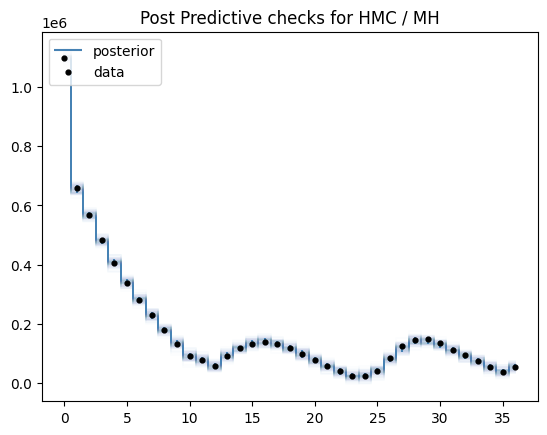

In [98]:


# Posterior predictive HMC
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'steelblue', label='posterior')

#     ## Posterior predictive MH
# plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive_MH.ExpData[0].T, alpha = 0.01, c = 'pink', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive_MH.ExpData[0],[.15,.85],axis=0), colors = 'pink', label='posterior')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'Post Predictive checks for HMC / MH')

# plt.savefig(f'{plot_name}')
plt.show()

## Testing the parameter order again

-> Also looks good

{'corr_bkg': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee460>},
 'corr_bkg1': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee3a0>},
 'corr_bkg2': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee370>},
 'lumi': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x1640ee520>},
 'mu': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x1640ee4c0>},
 'uncorr_bkg': {'slice': slice(5, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x1640ee550>},
 'uncorr_bkg1': {'slice': slice(8, 11, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x1640ee580>},
 'uncorr_bkg2': {'slice': slice(11, 14, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_poisson at 0x1640ee4f0>},
 'my_staterror': {

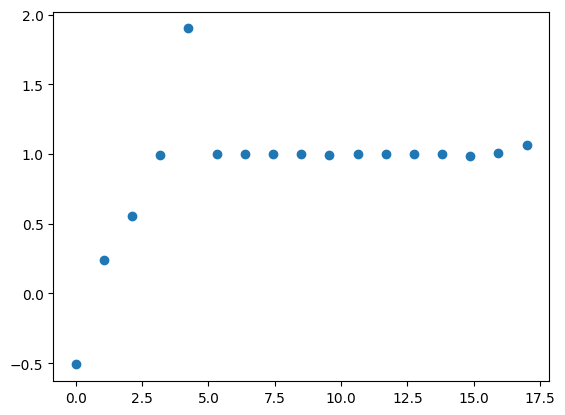

In [27]:
test = []
pars = prepare_inference.priors2pymc(prepared_model)
for i in range(nPars):
    test.append(pars[i].eval())

plt.scatter(np.linspace(0, nPars, nPars), test)

model.config.par_map